### Multiround UNL Attack Mixed

Figure 5abc, and 6c
Adjust the aggregation method accordingly based on hyperparameters (trimmed mean cutoff) to replicate results

Can also use this code to perform experiments for table 2

##### Summary
Load FAT model trained for 150 rounds and for 50 rounds try and inject FedAvg model into the system. Try different scaling rates and spread out the model replacement attack.

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 40
exp = "celeba"

# Load models for FAT and FedAvg - write down path to where weights are saved
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FedAvg/'
save_path_FedAvg_150R = save_path_FAT

# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 4.0
eps_train = 4.5
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator_og
except:
    aggregator_og, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator_og, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator_og, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..
get_celeba - Combining train batches... float16 version
get_celeba -Combining test batches... float16 version


 26%|██▌       | 39/150 [00:02<00:07, 15.77it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:16<00:00,  2.38it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [5]:
# Expand aggregator.mix() function
def UNL_mix_celeba_memory(aggregator, adv_id, robust_id, robust_model, model_inject, keys, weight_scale_2, 
dump_flag=False, aggregation_op = None, tm_beta = 0.05,  median_layers = []):

    weight_scale = 1/aggregator.clients_weights
    model_global = copy.deepcopy(aggregator.global_learners_ensemble[0].model)

    if aggregation_op == None:
        aggregation_op = aggregator.aggregation_op
        
    # Based on aggregation methods change weight scale
    if aggregation_op in ['median', 'krum']:# == "median" or aggregation_op == "krum":
        weight_scale = np.ones(weight_scale.shape)

    if aggregation_op in ['trimmed_mean']: # simple averaging takes place instead of weighted
        N_removed = int(tm_beta*len(aggregator.clients))
        weight_scale = np.ones(len(aggregator.clients))  * (len(aggregator.clients)-N_removed*2)
        print("trimmed mean, N removed: ", N_removed)
        print("weight scale: \n", weight_scale)

    # Give adversarial clients boosted models and train regular clients 1 round
    benign_id = list(range(len(aggregator.clients)))

    for r_id in robust_id:
        benign_id.remove(r_id)
        aggregator.clients[r_id].learners_ensemble[0].model.cpu()
        del aggregator.clients[r_id].learners_ensemble[0].model
        aggregator.clients[r_id].learners_ensemble[0].model = robust_model.cuda()

    if aggregation_op in ['median_sublayers']:
        N_removed = int(tm_beta*len(aggregator.clients))
        weight_scale = np.ones(len(aggregator.clients))  * (len(aggregator.clients)-N_removed*2)
        for a_id in adv_id:
            benign_id.remove(a_id)
            temp_atk_model = calc_atk_model_med_sublayer(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2, median_layers)
            aggregator.clients[a_id].learners_ensemble[0].model.cpu()
            del aggregator.clients[a_id].learners_ensemble[0].model
            aggregator.clients[a_id].learners_ensemble[0].model = temp_atk_model.cuda()
            del temp_atk_model
            gc.collect()
            torch.cuda.empty_cache()
    else:
        for a_id in adv_id:
            benign_id.remove(a_id)
            temp_atk_model = calc_atk_model(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)
            aggregator.clients[a_id].learners_ensemble[0].model.cpu()
            del aggregator.clients[a_id].learners_ensemble[0].model
            aggregator.clients[a_id].learners_ensemble[0].model = temp_atk_model.cuda()
            del temp_atk_model
            gc.collect()
            torch.cuda.empty_cache()

    for c_id in benign_id:
        aggregator.clients[c_id].step()

    # Aggregate model and download
    for learner_id, learner in enumerate(aggregator.global_learners_ensemble):
        learners = [client.learners_ensemble[learner_id] for client in aggregator.clients]
        if aggregation_op is None:
            average_learners(learners, learner, weights=aggregator.clients_weights)
        elif aggregation_op == 'median':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_median.pkl") 
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_median(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'median_sublayers':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_median_sublayers.pkl") 
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_median_sublayers(
                learners, 
                learner, 
                median_layers = median_layers,
                beta = tm_beta,
                dump_path=dump_path
            )
        elif aggregation_op == 'trimmed_mean':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_tm.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_tm(
                learners, 
                learner, 
                beta=tm_beta, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum_modelwise':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum_modelwise.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum_modelwise(
                1,
                learners,
                learner,
                dump_path=dump_path
            )
        else:
            raise NotImplementedError

    # Batchnorm buggy in mobilenet v2
    fix_model_stability(aggregator, model_global)
    del model_global
    gc.collect()
    torch.cuda.empty_cache()

    # assign the updated model to all clients
    aggregator.update_clients()

    aggregator.c_round += 1

In [6]:
num_aru = [5, 5, 10, 10]
beta_params = [0.05, 0.1, 0.1, 0.2]
weight2_list = [0.3, 0.2, 0.3, 0.2]
agg_options = ["trimmed_mean", "trimmed_mean", "trimmed_mean","trimmed_mean"]

# num_aru = [ 10]
# beta_params = [0.2]
# weight2_list = [0.1]
# agg_options = ["trimmed_mean"]

num_rounds = 20
eps = eps_attack

result_list = []
for itt in range(len(num_aru)):
    result_list += [{}]

# setting, num_user = "FedAvg_adv", 20
# aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp)
aggregator = aggregator_og

agg_choice = random.choices(range(3),k=num_rounds)

robust_id = range(15)

for itt in range(len(beta_params)):
    # Perform 50 rounds of FAT on FedAvg model 
    num_adv = num_aru[itt]
    weight2 = 1/num_adv * weight2_list[itt]
    adv_id = random.sample(range(25,num_user), num_adv) # excluding 0-9 as Fu = 1
    beta = beta_params[itt]

    test_acc_gather = []
    adv_acc_gather = []
    test_acc_std = []
    adv_acc_std = []
    cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

    aggregator.tm_rate = beta

    # Test performance of aggregator on data 
    aggregator.load_state(dir_path = save_path_FedAvg_150R)
    aggregator.update_clients()
    model_FA = pull_model_from_agg(aggregator)
    model_FA.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_FA, eps = eps)

    # prev_model = copy.deepcopy(model_FA)

    print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    test_acc_std += [np.std(acc)]
    adv_acc_std += [np.std(adv_acc)]



    for i in range(num_rounds):

        # Per round Freq
        aggregator.aggregation_op = agg_options[itt]

        # aggregator.mix()
        # UNL_mix(aggregator, adv_id, model_inject = model_Fedavg, keys = desired_keys, weight_scale_2 = weight2, dump_flag=False, tm_beta=beta)
        UNL_mix_celeba_memory(aggregator, adv_id, robust_id, robust_model = model_FAT, model_inject = model_Fedavg, keys= desired_keys, weight_scale_2 = weight2, 
                dump_flag=False, aggregation_op = None, tm_beta = beta,  median_layers = [])
        model_overfit = pull_model_from_agg(aggregator)
        model_overfit.eval()
        acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps = eps)

        print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
        test_acc_gather+= [np.mean(acc)]
        adv_acc_gather += [np.mean(adv_acc)]
        test_acc_std += [np.std(acc)]
        adv_acc_std += [np.std(adv_acc)]
        # prev_model = copy.deepcopy(model_overfit)

        result_list[itt]['test_acc'] = copy.deepcopy(test_acc_gather)
        result_list[itt]['adv_acc'] = copy.deepcopy(adv_acc_gather)
        result_list[itt]['test_std'] = copy.deepcopy(test_acc_std)
        result_list[itt]['adv_std'] = copy.deepcopy(adv_acc_std)
        result_list[itt]['num_clients'] = num_adv
        result_list[itt]['beta'] = beta
        result_list[itt]['weight2'] = weight2_list[itt]
        # Perform gradient direction gathering

        del model_overfit
        gc.collect()
        torch.cuda.empty_cache()


    

Test acc:  0.7995882391929626 adv acc:  0.5066931426525116
trimmed mean, N removed:  2
weight scale: 
 [36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00
 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00
 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00
 36.00 36.00 36.00 36.00]


/home/ubuntu/fedatk_unl_tj/learners/learner.py:192: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


Successfully copied values of 'features.17.conv.1.1.running_var' from source_model to target_model.
Values of 'features.17.conv.1.1.running_var' successfully updated in the new model.
round 0 Test acc:  0.8261872574687004 adv acc:  0.495287261530757
trimmed mean, N removed:  2
weight scale: 
 [36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00
 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00
 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00
 36.00 36.00 36.00 36.00]
Successfully copied values of 'features.17.conv.1.1.running_var' from source_model to target_model.
Values of 'features.17.conv.1.1.running_var' successfully updated in the new model.
round 1 Test acc:  0.8074921607971192 adv acc:  0.3809686338528991
trimmed mean, N removed:  2
weight scale: 
 [36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00
 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00 36.00
 36.00 36.00 36.00 3

In [7]:
import pickle

a = result_list

with open('saved_results/mixed_sweep/250128_5b_tm_arui_celeba.pk', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('saved_results/mixed_sweep/250128_5b_tm_arui_celeba.pk', 'rb') as handle:
    result_list = pickle.load(handle)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


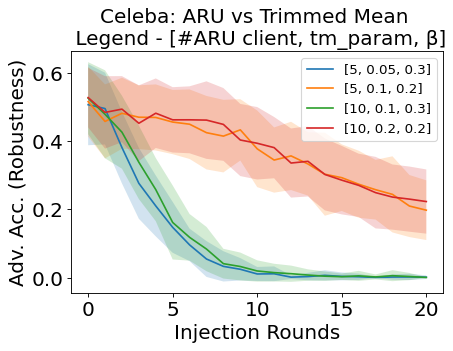

In [8]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

plot_settings = [[5 ,0.05,0.3],[5 ,0.1, 0.2],[10, 0.1, 0.3], [10, 0.2, 0.2]]

num_aru = [5, 5, 10, 10]
beta_params = [0.05, 0.1, 0.1, 0.2]
weight2_list = [0.3, 0.2, 0.3, 0.2]
agg_options = ["trimmed_mean", "trimmed_mean", "trimmed_mean","trimmed_mean"]

# Generate some sample data
x = range(num_rounds+1)  # 100 points from 0 to 10

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
label_list = plot_settings
for i in range(len(label_list)):
    y = np.array(result_list[i]['adv_acc'])
    error = np.array(result_list[i]['adv_std'])
    plt.plot(x, y, label= str(label_list[i]))
    plt.fill_between(x, y-error, y+error,
    alpha=0.2)

# Adding labels and title
plt.xlabel('Injection Rounds')
plt.ylabel('Adv. Acc. (Robustness)')
plt.title('Celeba: ARU vs Trimmed Mean \n Legend - [#ARU client, tm_param, β]', fontsize = 'medium')

# Adding a legend
plt.legend( loc="best", fontsize=12)


# Display the plot
plt.show()
